Predicts the volume of bikes needed on various days in May 2021. Uses this dataset: https://www.kaggle.com/datasets/farjadanalytica/divvytripdata-1?select=202105-divvy-tripdata.csv 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
df_divvy = pd.read_csv('202105-divvy-tripdata.csv', on_bad_lines='skip')
df_divvy[:20]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0F3AE375DEC608D9,classic_bike,5/2/2021 8:21,5/2/2021 9:20,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual
1,43E916C72D4C77B3,electric_bike,5/1/2021 22:15,5/1/2021 22:51,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.901037,-87.623789,41.900775,-87.623852,casual
2,2AAB47362E76AC7F,electric_bike,5/31/2021 0:50,5/31/2021 0:56,Clark St & Grace St,TA1307000127,Clark St & Leland Ave,TA1309000014,41.950929,-87.659147,41.967092,-87.667394,casual
3,344011882FBBB8BD,classic_bike,5/31/2021 7:35,5/31/2021 8:33,Sheridan Rd & Noyes St (NU),604,Sheridan Rd & Noyes St (NU),604,42.058239,-87.677432,42.058239,-87.677432,casual
4,238E58CAB07FA2A8,electric_bike,5/2/2021 16:55,5/2/2021 16:57,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900995,-87.623736,41.900992,-87.623726,casual
5,BF99592737266B31,classic_bike,5/7/2021 6:03,5/7/2021 7:12,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual
6,059C6EFD3DA52B3C,classic_bike,5/19/2021 18:04,5/19/2021 18:51,Sheridan Rd & Noyes St (NU),604,Sheridan Rd & Noyes St (NU),604,42.058239,-87.677432,42.058239,-87.677432,casual
7,F1FDE9F333E8A72F,classic_bike,5/30/2021 16:41,5/30/2021 16:56,Kingsbury St & Kinzie St,KA1503000043,Larrabee St & Armitage Ave,TA1309000006,41.889177,-87.638506,41.918084,-87.643749,casual
8,13576FA2EB822C12,classic_bike,5/24/2021 17:59,5/24/2021 18:01,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual
9,033FBC7213DC960B,classic_bike,5/24/2021 18:04,5/24/2021 18:36,Michigan Ave & Oak St,13042,Michigan Ave & Oak St,13042,41.900960,-87.623777,41.900960,-87.623777,casual


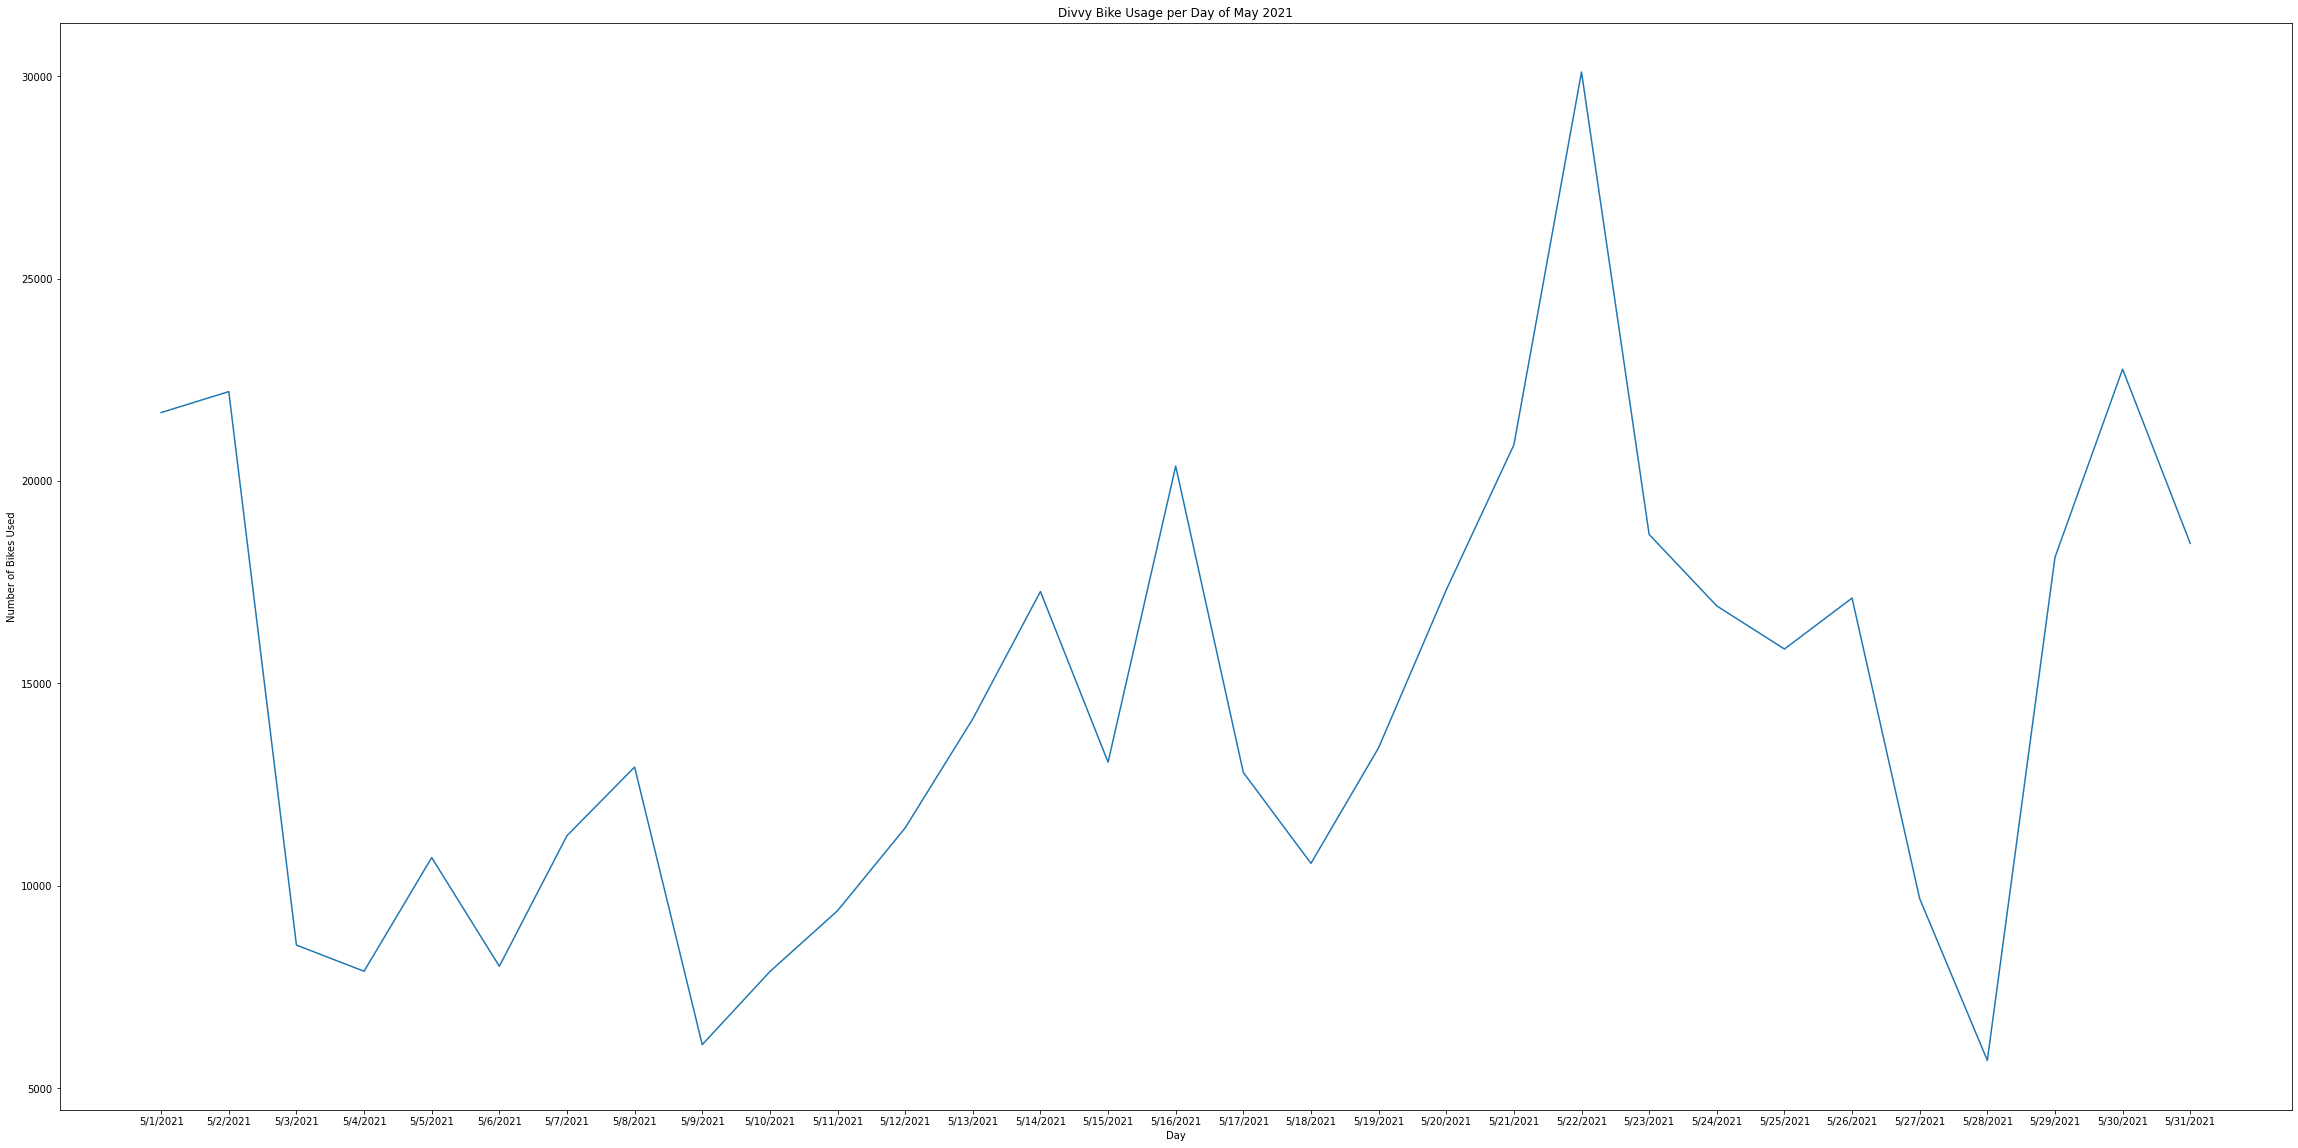

In [ ]:
# Find total number of bikes used on each day
df_divvy['start_date'] = df_divvy['started_at'].apply(lambda x: str(x).split(' ')[0]) # day on which the bike ride started
#df_station = df_divvy[df_divvy['start_station_name'] == 'State St & 19th St']
start_dates = list(df_divvy['start_date'])
#start_dates = list(df_station['start_date'])

# sorted counts for start date
start_date_counts = {} # key: date (string), value: number of bikes used that day (int)
for i in range (1,32): # Create sorted dictionary
  date = '5/' + str(i) + '/2021'
  start_date_counts[date] = 0
for date in start_dates:
  start_date_counts[date] += 1

plt.figure(figsize=(40, 20))
plt.plot(list(start_date_counts.keys()), list(start_date_counts.values()))
plt.title('Divvy Bike Usage per Day of May 2021')
plt.xlabel('Day')
plt.ylabel('Number of Bikes Used')
plt.savefig('bike_usage_per_day.png')

In [ ]:
# Prepare the data to be passed into the logistic regression model
"""
days_of_week_mappings = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
x = [] # days of week as numbers, using the numbers in days_of_week_mappings. 5/1/2021 is Saturday

current_day = 6
for i in range(31):
  x.append(current_day)
  if current_day < 6:
    current_day += 1
  else:
    current_day = 0 
"""
#x = np.arange(1,32) # each day of May
x = np.array([[x] for x in range(1,32)])
y = list(start_date_counts.values()) # number of bikes used on each day

In [ ]:
# Train and test linear regression model
"""
lin_reg_model = stats.linregress(x, y)
print(f"R-squared: {lin_reg_model.rvalue**2:.6f}")
print(f"Intercept: {lin_reg_model.intercept:.6f}")
print(f"Slope: {lin_reg_model.slope:.6f}")
"""
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
coef = linear_model.coef_
intercept = linear_model.intercept_
print(linear_model.score(X_test, y_test)) # R^2
print(coef)
print(intercept)

0.13130358386247698
[190.88193775]
11777.85918641037


In [ ]:
# Cross validation
cv_results = cross_validate(linear_model, X_train, y_train, cv=10)
print(cv_results)
print(np.average(cv_results['fit_time']))
print(np.average(cv_results['score_time']))
print(np.average(cv_results['test_score']))

{'fit_time': array([0.00122929, 0.00085545, 0.00081086, 0.00075054, 0.00078702,
       0.00080729, 0.00075984, 0.00074315, 0.00077009, 0.00071287]), 'score_time': array([0.00062895, 0.00050187, 0.00048208, 0.00052238, 0.00048018,
       0.0005362 , 0.0006237 , 0.00050998, 0.00055575, 0.00050545]), 'test_score': array([-4.19492562e-01, -3.93910642e+00,  2.47756215e-02, -1.16186548e+00,
       -1.70516856e+00, -1.40337354e+01, -2.07160459e+00, -5.48136245e+01,
       -8.93004195e+00, -7.13656838e-01])}
0.0008226394653320313
0.0005346536636352539
-8.776352060150064


In [ ]:
parameters = {'alpha': [pow(10,i) for i in range(0,20)]}
clf = GridSearchCV(Ridge(), parameters, cv=5)
clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([0.00199666, 0.0005507 , 0.00053477, 0.00053468, 0.00052757,
        0.00052114, 0.00052619, 0.00060902, 0.00082426, 0.00059566,
        0.00052643, 0.00059161, 0.00053935, 0.0005312 , 0.00053306,
        0.00052261, 0.0005259 , 0.00056767, 0.00053735, 0.00052314]),
 'mean_score_time': array([0.00060329, 0.0003068 , 0.00027823, 0.0002851 , 0.0002902 ,
        0.00028324, 0.00028658, 0.00033937, 0.00042849, 0.00029793,
        0.00027952, 0.00031137, 0.00028229, 0.00027952, 0.0002779 ,
        0.00028038, 0.00028052, 0.00029001, 0.00027919, 0.00028014]),
 'mean_test_score': array([-0.78370655, -0.78427408, -0.79018248, -0.84590507, -0.97047131,
        -1.00831967, -1.01283436, -1.01329445, -1.01334054, -1.01334515,
        -1.01334562, -1.01334566, -1.01334567, -1.01334567, -1.01334567,
        -1.01334567, -1.01334567, -1.01334567, -1.01334567, -1.01334567]),
 'param_alpha': masked_array(data=[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000,
                

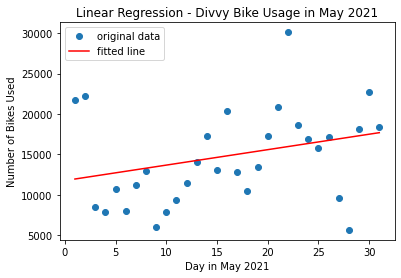

In [ ]:
# Create plot showing regression line
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + coef[0]*x, 'r', label='fitted line')
plt.legend()
#plt.show()
plt.xlabel('Day in May 2021')
plt.ylabel('Number of Bikes Used')
plt.title('Linear Regression - Divvy Bike Usage in May 2021')
plt.savefig('lin_reg_divvy_bikes.png')

In [ ]:
# Polynomial fit
#polynomial_model = np.poly1d(np.polyfit(x, y, 5))
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(X_train) # x, x^2, x^3
print(poly_features)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
coef = poly_reg_model.coef_
intercept = poly_reg_model.intercept_
X_test_features = poly.fit_transform(X_test)
print(poly_reg_model.score(X_test_features, y_test)) # R^2
print(coef)
print(intercept)



[[1.2000e+01 1.4400e+02 1.7280e+03]
 [1.8000e+01 3.2400e+02 5.8320e+03]
 [2.4000e+01 5.7600e+02 1.3824e+04]
 [6.0000e+00 3.6000e+01 2.1600e+02]
 [1.7000e+01 2.8900e+02 4.9130e+03]
 [9.0000e+00 8.1000e+01 7.2900e+02]
 [1.5000e+01 2.2500e+02 3.3750e+03]
 [2.5000e+01 6.2500e+02 1.5625e+04]
 [2.1000e+01 4.4100e+02 9.2610e+03]
 [2.0000e+00 4.0000e+00 8.0000e+00]
 [3.1000e+01 9.6100e+02 2.9791e+04]
 [7.0000e+00 4.9000e+01 3.4300e+02]
 [5.0000e+00 2.5000e+01 1.2500e+02]
 [1.9000e+01 3.6100e+02 6.8590e+03]
 [2.9000e+01 8.4100e+02 2.4389e+04]
 [2.0000e+01 4.0000e+02 8.0000e+03]
 [1.0000e+01 1.0000e+02 1.0000e+03]
 [8.0000e+00 6.4000e+01 5.1200e+02]
 [2.7000e+01 7.2900e+02 1.9683e+04]
 [4.0000e+00 1.6000e+01 6.4000e+01]
 [1.0000e+00 1.0000e+00 1.0000e+00]
 [2.2000e+01 4.8400e+02 1.0648e+04]
 [1.6000e+01 2.5600e+02 4.0960e+03]
 [1.3000e+01 1.6900e+02 2.1970e+03]]
-0.21102156885792578
[-3494.36984425   261.07383929    -5.11025084]
23630.909567723793


In [ ]:
# Cross validation
cv_results = cross_validate(poly_reg_model, poly_features, y_train, cv=10)
print(cv_results)
print(np.average(cv_results['fit_time']))
print(np.average(cv_results['score_time']))
print(np.average(cv_results['test_score']))

{'fit_time': array([0.00103855, 0.00211668, 0.00324321, 0.00061131, 0.00057626,
       0.00053811, 0.00049448, 0.00048685, 0.00048184, 0.00048661]), 'score_time': array([0.00058722, 0.00057554, 0.00041151, 0.00030279, 0.00030708,
       0.00029135, 0.00031114, 0.00033474, 0.00031638, 0.00033641]), 'test_score': array([-9.41552987e-01, -7.32182321e-01,  2.50043229e-01, -1.75467765e+00,
       -2.65677100e+00, -3.49718742e+00, -9.87243380e-02, -1.00922192e+02,
       -4.38083411e+00, -2.93251470e+00])}
0.001007390022277832
0.00037741661071777344
-11.766659306085314


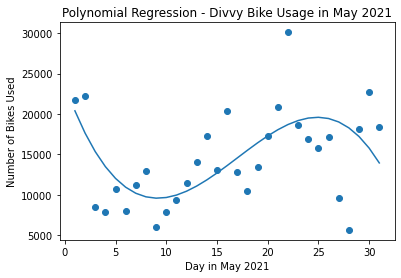

In [ ]:
plt.scatter(x, y)
#plt.plot(x, polynomial_model(x))
plt.plot(x, x * coef[0] + np.power(x,2) * coef[1] + np.power(x,3) * coef[2] + intercept)
#plt.show()
plt.xlabel('Day in May 2021')
plt.ylabel('Number of Bikes Used')
plt.title('Polynomial Regression - Divvy Bike Usage in May 2021')
plt.savefig('polynomial_reg_divvy_bikes.png')

#print(r2_score(y, polynomial_model(x)))
#print(polynomial_model) # coefficients